# imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import sklearn

# sklearn
from sklearn import model_selection # split함수이용
from sklearn import ensemble # RF,GBM
from sklearn import metrics 

# embedding 
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

/home/cgb2/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df=df_input.copy()
    mapping={x:node_id for node_id, x in enumerate(set(df["cc_num"].values.tolist()+\
                                                      df["merchant"].values.tolist()))}
    
    df["from"]=df["cc_num"].apply(lambda x:mapping[x])  #엣지의 출발점
    df["to"]=df["merchant"].apply(lambda x:mapping[x])  #엣지의 도착점
    
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from','to']).agg({"is_fraud":"sum","amt":"sum"}).reset_index()
    df["is_fraud"]=df["is_fraud"].apply(lambda x:1 if x>0 else 0)
    
    G=nx.from_edgelist(df[["from","to"]].values, create_using=graph_type)
    
    nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, "label")  #엣지 속성 설정,각 속성의 사기 여부부     
    nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["amt"] for idx,x in df[["from","to","amt"]].iterrows()}, "weight") # 엣지 속성 설정, 각 엣지의 거래 금액

    return G


def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df=df_input.copy()
    mapping={x:node_id for node_id, x in enumerate(set(df.index.values.tolist() + 
                                                       df["cc_num"].values.tolist() +
                                                       df["merchant"].values.tolist()))}
    df["in_node"]= df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"]=df["merchant"].apply(lambda x:mapping[x])
    
        
    G=nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +\
                        [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], create_using=graph_type)
    
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")     
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")   
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")  
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")

    return G
    
    
def down_sample_textbook(df):
    df_majority = df[df.is_fraud==0].copy()
    df_minority = df[df.is_fraud==1].copy()
    df_maj_dowsampled = sklearn.utils.resample(df_majority, n_samples=len(df_minority), replace=False, random_state=42)
    df_downsampled = pd.concat([df_minority, df_maj_dowsampled])
    return df_downsampled

def embedding(Graph):
    # Graph -> X (feature)
    _edgs = list(Graph.edges)
    subGraph = Graph.edge_subgraph([_edgs[x] for x in range(len(Graph.edges))]).copy()
    subGraph.add_nodes_from(list(set(Graph.nodes) - set(subGraph.nodes)))    
    embedded = AverageEmbedder(Node2Vec(subGraph, weight_key='weight').fit(window=10).wv)
    X = [embedded[str(_edgs[x][0]), str(_edgs[x][1])] for x in range(len(Graph.edges))]
    # Graph -> y (label)
    y = np.array(list(nx.get_edge_attributes(Graph, "label").values()))
    return X,y 

def anal(df):
    Graph = build_graph_bipartite(df)
    X,XX,y,yy = embedding(Graph)
    lrnr = RandomForestClassifier(n_estimators=100, random_state=42) 
    lrnr.fit(X,y)
    yyhat = lrnr.predict(XX)
    df = pd.DataFrame({
        'acc':[sklearn.metrics.accuracy_score(yy,yyhat)], 
        'pre':[sklearn.metrics.precision_score(yy,yyhat)], 
        'rec':[sklearn.metrics.recall_score(yy,yyhat)],
        'f1':[sklearn.metrics.f1_score(yy,yyhat)]}
    )    
    return df

def our_sampling1(df):
    cus_list = set(df.query('is_fraud==1').cc_num.tolist())
    return df.query("cc_num in @ cus_list")

# Overview

## 데이터 종류 

- fraudTrain.csv: (1048575, 23), 기본데이터
- df02: (214520, 23), is_fraud==0 에서는 20퍼의 샘플만, is_fraud==1 에서는 모든 샘플을 뽑아서 정리한 새로운 자료
- df50 = (12012, 23), df20에서 is_fraud==0 와 is_fraud==1 의 비율을 맞추어서 샘플을 뽑은 것 

|데이터|shape|사기거래빈도|설명|
|-|-|-|-|
|fraudTrain|(1048575, 22)|0.00573|원래자료|
|df02|(214520, 22)|0.028| is_fraud==0 에서는 20퍼의 샘플만, is_fraud==1 에서는 모든 샘플을 뽑아서 정리한 새로운 자료|
|df50|(12012, 22)|0.5| df02에서 사기비율을 50퍼로 맞추어 샘플링한 자료|
|df50_tr|(9009, 22)|0.49828| df50에서 랜덤으로 train/test를 분리하여 얻은 train dataset|
|df50_test|(3003, 22)|0.50516| df50에서 랜덤으로 train/test를 분리하여 얻은 test dataset|
|df02_tr|(211517, 22)|0.02122| df02에서 df50_test에 해당하는 인덱스를 제외|
|fraudTrain_tr|(1045572, 22)|0.00429| fraudTrain에서 df50_test에 해당하는 인덱스를 제외|

`-` fraudTrain

In [276]:
fraudTrain = pd.read_csv("fraudTrain.csv").iloc[:,1:]

In [277]:
fraudTrain.is_fraud.mean().round(5)

0.00573

`-` df20

In [278]:
_df1 = fraudTrain[fraudTrain["is_fraud"] == 0].sample(frac=0.20, random_state=42)
_df2 = fraudTrain[fraudTrain["is_fraud"] == 1]
df02 = pd.concat([_df1,_df2])
df02.shape

(214520, 22)

In [279]:
df02.is_fraud.mean().round(5)

0.028

`-` df50

In [280]:
df50 = down_sample_textbook(df02)
df50.shape

(12012, 22)

In [281]:
df50

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
2449,2019-01-02 1:06,4.613310e+12,fraud_Rutherford-Mertz,grocery_pos,281.06,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,...,35.9946,-81.7266,885,Soil scientist,1988-09-15,e8a81877ae9a0a7f883e15cb39dc4022,1325466397,36.430124,-81.179483,1
2472,2019-01-02 1:47,3.401870e+14,"fraud_Jenkins, Hauck and Friesen",gas_transport,11.52,Misty,Hart,F,27954 Hall Mill Suite 575,San Antonio,...,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,bc7d41c41103877b03232f03f1f8d3f5,1325468849,29.819364,-99.142791,1
2523,2019-01-02 3:05,3.401870e+14,fraud_Goodwin-Nitzsche,grocery_pos,276.31,Misty,Hart,F,27954 Hall Mill Suite 575,San Antonio,...,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,b98f12f4168391b2203238813df5aa8c,1325473523,29.273085,-98.836360,1
2546,2019-01-02 3:38,4.613310e+12,fraud_Erdman-Kertzmann,gas_transport,7.03,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,...,35.9946,-81.7266,885,Soil scientist,1988-09-15,397894a5c4c02e3c61c784001f0f14e4,1325475483,35.909292,-82.091010,1
2553,2019-01-02 3:55,3.401870e+14,fraud_Koepp-Parker,grocery_pos,275.73,Misty,Hart,F,27954 Hall Mill Suite 575,San Antonio,...,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,7863235a750d73a244c07f1fb7f0185a,1325476547,29.786426,-98.683410,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363827,2019-06-17 19:30,2.475090e+15,fraud_Frami Group,entertainment,81.13,John,Miller,M,153 Mccullough Springs Apt. 857,Lamberton,...,44.2378,-95.2739,1507,Land/geomatics surveyor,1993-10-12,c66cb411019c7dfd4d89f42a1ba4765f,1339961448,44.212695,-95.661879,0
140154,2019-03-17 14:33,2.131550e+14,fraud_Bahringer-Streich,food_dining,55.00,Christopher,Sheppard,M,39218 Baker Shoals,Bristow,...,38.1981,-86.6821,965,Horticultural therapist,1982-02-10,316b9d25b9fa7d08a6831b7dab6634cd,1331994839,38.394240,-86.413557,0
860597,2019-12-17 12:31,2.280870e+15,fraud_Lubowitz-Walter,kids_pets,8.12,Katherine,Cooper,F,3854 Lauren Springs Suite 648,Oakford,...,40.0994,-89.9601,530,Transport planner,1967-09-23,d92e9e63d9b24c3ccb92d05cba4cac54,1355747517,39.695248,-89.853063,0
29341,2019-01-18 9:20,4.878360e+15,fraud_Denesik and Sons,shopping_pos,3.52,Tina,Alvarez,F,1976 Tyler Underpass,Early,...,42.4483,-95.1726,885,"Pilot, airline",1949-08-14,8390ce51cfb8482b618ebc4ac370bcf7,1326878457,42.633204,-95.598143,0


In [282]:
df50.is_fraud.mean().round(5)

0.5

`-` df50_tr, df50_test 

In [283]:
df50_tr,df50_test = sklearn.model_selection.train_test_split(df50, random_state=42)

In [284]:
df50_tr.is_fraud.mean().round(5), df50_test.is_fraud.mean().round(5)

(0.49828, 0.50516)

`-` df02_tr, fraudTrain_tr

In [285]:
df02_tr = df02.loc[[i not in df50_test.index for i in df02.index],:].copy()
fraudTrain_tr = fraudTrain.loc[[i not in df50_test.index for i in fraudTrain.index],:].copy()

In [286]:
df02_tr.shape, fraudTrain_tr.shape

((211517, 22), (1045572, 22))

In [287]:
df02_tr.is_fraud.mean().round(5), fraudTrain_tr.is_fraud.mean().round(5)

(0.02122, 0.00429)

# 분석방법정리 

||Train|Test|모형|설명변수|참고|
|-|-|-|-|-|-|
|분석1|df50train|df50test|로지스틱|amt|쓰레기|
|분석2|df50train|df50test|그레디언트부스팅|amt|base|
|**분석3**|df50train|df50test|그레디언트부스팅|amt,amtano|가장좋음|
|분석4|df02train|df50test|그레디언트부스팅|amt,amtano|가능성있음|
|분석5|fraudTrain_tr|df50test|그레디언트부스팅|amt,amtano|가능성있음|

In [288]:
lst = [_results2,_results3]
pd.concat(lst)

,accuracy_score,precision_score,recall_score,f1_score
분석2,0.885781,0.908206,0.86091,0.883926
분석3,0.885781,0.908206,0.86091,0.883926


# 분석2

`-` step1: data 

In [465]:
X = np.array(df02_tr.loc[:,['amt']])
XX = np.array(df50_test.loc[:,['amt']])
y = np.array(df02_tr.is_fraud)
yy = np.array(df50_test.is_fraud)

`-` step2: lrnr 생성 

In [466]:
lrnr = ensemble.GradientBoostingClassifier()

`-` step3: fit 

In [467]:
lrnr.fit(X,y)

GradientBoostingClassifier()

`-` step4: evaluate

In [468]:
thresh = y.mean()
yyhat = (lrnr.predict_proba(XX)> thresh)[:,-1]
#yyhat = lrnr.predict(XX) 

In [469]:
metrics = [sklearn.metrics.accuracy_score,
           sklearn.metrics.precision_score,
           sklearn.metrics.recall_score,
           sklearn.metrics.f1_score]

In [470]:
_results2= pd.DataFrame({m.__name__:[m(yy,yyhat).round(6)] for m in metrics},index=['분석2'])
_results2

,accuracy_score,precision_score,recall_score,f1_score
분석2,0.88678,0.910677,0.86025,0.884746


# 분석3 

`-` step1: data 

In [471]:
def amtano(df_train):
    df = df_train.copy()
    df = df.assign(amtano1=0)
    df = df.assign(amtano2=0)
    df = df.assign(amtano3=0)
    normalize = lambda arr: (arr-np.median(arr)) if np.std(arr)!=0 else arr*0 
    rollmax = lambda arr: arr.rolling(window=3, min_periods=1).max()
    rollmin = lambda arr: arr.rolling(window=3, min_periods=1).min()    
    rollmean = lambda arr: arr.rolling(window=3, min_periods=1).mean()    
    rollstd = lambda arr: arr.rolling(window=3, min_periods=1).std()    
    for cc_num, sub_df in df.groupby('cc_num'):
        df.loc[df.cc_num == cc_num,['amtano1']] = normalize(sub_df.amt)
        df.loc[df.cc_num == cc_num,['amtano2']] = (sub_df.amt * rollmean(normalize(sub_df.amt)))/rollmin(sub_df.amt)
        df.loc[df.cc_num == cc_num,['amtano3']] = rollmin(normalize(sub_df.amt))
    return df  

In [473]:
df02_tr2 = amtano(df02_tr)
df50_test2 = amtano(df50_test)

X = np.array(df02_tr2.loc[:,['amtano2']])
XX = np.array(df50_test2.loc[:,['amtano2']])
y = np.array(df02_tr.is_fraud)
yy = np.array(df50_test.is_fraud)

In [475]:
cclist = df02_tr2.cc_num.unique().tolist()

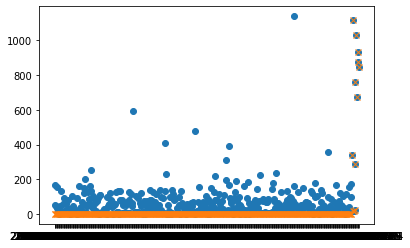

In [497]:
i=190
plt.plot(df02_tr2.query('cc_num==@cclist[@i]').trans_date_trans_time, df02_tr2.query('cc_num==@cclist[@i]').amt,'o')
plt.plot(df02_tr2.query('cc_num==@cclist[@i]').trans_date_trans_time, df02_tr2.query('cc_num==@cclist[@i]').is_fraud*df02_tr2.query('cc_num==@cclist[@i]').amt,'x')

`-` step2: lrnr 생성 

In [406]:
lrnr = ensemble.GradientBoostingClassifier()

`-` step3: fit 

In [407]:
lrnr.fit(X,y)

GradientBoostingClassifier()

`-` step4: evaluate

In [408]:
# thresh = y.mean()
# yyhat = (lrnr.predict_proba(XX)> thresh)[:,-1]
yyhat = lrnr.predict(XX) 

In [409]:
metrics = [sklearn.metrics.accuracy_score,
           sklearn.metrics.precision_score,
           sklearn.metrics.recall_score,
           sklearn.metrics.f1_score]

In [410]:
_results3= pd.DataFrame({m.__name__:[m(yy,yyhat).round(6)] for m in metrics},index=['분석3'])
_results3

,accuracy_score,precision_score,recall_score,f1_score
분석3,0.670663,0.790749,0.473303,0.592165
